In [1]:
import importlib
import subprocess

def import_or_install(package):
            try:
                importlib.import_module(package)
                print(f'{package} is already installed')
            except ImportError:
                print(f'{package} is not installed, installing now...')
                subprocess.check_call(['pip', 'install', package])
                print(f'{package} has been installed')

import_or_install('pandas')
import_or_install('scikit-learn')
import_or_install('numpy')
import_or_install('tensorflow')
import_or_install('keras')

import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import date
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np

pandas is already installed
scikit-learn is not installed, installing now...
scikit-learn has been installed
numpy is already installed
tensorflow is already installed
keras is already installed


In [47]:
try:
    data = pd.read_csv('../data/cleaned_data.csv')
except:
    data = pd.read_csv('~/Documents/GitHub/Finance-LLM/data/cleaned_data.csv')
data_original = data.copy()
data.head()

,date,close,volume,day,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,interest_rates,benz_rate
0,2018-05-04,244.288,91222100.0,4.0,0.039,-0.012,0.051,-190.728,-260.374,-260.374,-205.515,-205.515,-370.093,-370.093,1.640,62.119,62.119,242.621,242.621,242.621,242.621,14.77,118.99,101.64,83.19,1.7,7.189
1,2018-05-07,245.114,55304900.0,0.0,0.127,0.029,0.097,-155.361,-225.370,-225.370,-212.133,-212.133,-251.843,-251.843,2.107,67.818,67.818,243.120,243.120,243.120,243.120,14.75,118.80,101.59,83.19,1.7,7.667
2,2018-05-08,245.114,67499200.0,1.0,0.177,0.069,0.108,-155.361,-202.033,-202.033,-208.767,-208.767,-188.567,-188.567,2.107,67.818,67.818,243.452,243.452,243.452,243.452,14.71,118.69,101.42,83.20,1.7,6.600
3,2018-05-09,247.483,59666100.0,2.0,0.313,0.131,0.182,-106.900,-170.322,-170.322,-195.952,-195.952,-119.063,-119.063,3.661,78.548,78.548,244.028,244.028,244.028,244.028,13.42,117.98,101.19,83.16,1.7,7.111
4,2018-05-10,249.797,72063900.0,3.0,0.510,0.222,0.288,-69.359,-136.668,-136.668,-176.191,-176.191,-57.623,-57.623,5.296,84.118,84.118,244.749,244.749,244.749,244.749,13.23,118.93,101.40,83.16,1.7,9.000


In [48]:
data_original.tail()

,date,close,volume,day,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,interest_rates,benz_rate
1254,2023-04-28,415.93,89335600.0,4.0,2.842,3.201,-0.359,99.918,63.463,63.463,54.926,54.926,80.537,80.537,1.588,61.366,61.366,401.801,401.801,392.918,392.918,15.78,106.46,99.73,82.18,4.83,7.583
1255,2023-05-01,415.51,62122300.0,0.0,3.007,3.162,-0.155,84.754,70.560,70.560,60.137,60.137,91.406,91.406,1.542,60.657,60.657,401.977,401.977,393.129,393.129,16.08,103.13,98.32,81.81,4.83,7.200
1256,2023-05-02,410.84,103998500.0,1.0,2.731,3.076,-0.345,51.012,64.044,64.044,61.439,61.439,69.253,69.253,1.141,53.285,53.285,402.079,402.079,393.281,393.281,17.78,105.70,99.60,82.08,4.83,5.429
1257,2023-05-03,408.02,91531800.0,2.0,2.258,2.912,-0.655,30.636,52.908,52.908,58.595,58.595,41.532,41.532,0.976,49.381,49.381,402.288,402.288,393.435,393.435,18.34,106.29,100.25,82.28,4.83,3.500
1258,2023-05-04,405.13,94901900.0,3.0,1.631,2.656,-1.025,10.015,38.610,38.610,51.934,51.934,11.963,11.963,0.841,45.688,45.688,402.450,402.450,393.524,393.524,20.09,105.24,100.23,82.41,5.08,8.000


In [49]:
data.columns

Index(['date', 'close', 'volume', 'day', 'macd', 'macds', 'macdh', 'rsv_9',
       'kdjk_9', 'kdjk', 'kdjd_9', 'kdjd', 'kdjj_9', 'kdjj', 'rs_14', 'rsi_14',
       'rsi', 'close_50_sma', 'ma50', 'close_200_sma', 'ma200', 'vix', 'TLT',
       'IEF', 'SHY', 'interest_rates', 'benz_rate'],
      dtype='object')

In [50]:
# Preprocess date column
data['Date'] = pd.to_datetime(data['date'])
data.drop(['date'], axis=1, inplace=True)

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data = pd.get_dummies(data, columns=['Month'])  # one-hot encode month column

# set the 'date' column as the DataFrame's index
data.set_index('Date', inplace=True)

# lag the 'close_price' column by 180 trading days
data['close_price_lagged'] = data['close'].shift(-6*30)

# reset the index back to a column
data.reset_index(inplace=True)

# create new data as last 180 trading days of data
new_data = data[data['close_price_lagged'].isna()==True].copy().drop(['close_price_lagged'], axis=1)
data_orig_final = data.copy()
data = data[data['close_price_lagged'].isna()==False].copy()

data = data.drop('Date', axis=1)
new_data_original = new_data.copy()
new_data = new_data.drop('Date', axis=1)

# scale data
scaler = StandardScaler()
data.iloc[:, 1:28] = scaler.fit_transform(data.iloc[:, 1:28])  # standardize year and day columns
new_data.iloc[:, 1:28] = scaler.fit_transform(new_data.iloc[:, 1:28])

X = data.drop('close_price_lagged', axis=1).values
y = data['close_price_lagged'].values.reshape(-1, 1)
new_data_X = new_data.values

# reshape for LSTM
X = X.reshape(X.shape[0], 1, X.shape[1])  # reshape to 3D array
new_data_X = new_data_X.reshape(new_data_X.shape[0], 1, new_data_X.shape[1])

In [6]:
print(data.shape, new_data.shape)

(1079, 41) (180, 40)


In [7]:
data_orig_final.tail()

,Date,close,volume,day,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,interest_rates,benz_rate,Year,Day,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,close_price_lagged
1254,2023-04-28,415.93,89335600.0,4.0,2.842,3.201,-0.359,99.918,63.463,63.463,54.926,54.926,80.537,80.537,1.588,61.366,61.366,401.801,401.801,392.918,392.918,15.78,106.46,99.73,82.18,4.83,7.583,2023,28,0,0,0,1,0,0,0,0,0,0,0,0,NaN
1255,2023-05-01,415.51,62122300.0,0.0,3.007,3.162,-0.155,84.754,70.560,70.560,60.137,60.137,91.406,91.406,1.542,60.657,60.657,401.977,401.977,393.129,393.129,16.08,103.13,98.32,81.81,4.83,7.200,2023,1,0,0,0,0,1,0,0,0,0,0,0,0,NaN
1256,2023-05-02,410.84,103998500.0,1.0,2.731,3.076,-0.345,51.012,64.044,64.044,61.439,61.439,69.253,69.253,1.141,53.285,53.285,402.079,402.079,393.281,393.281,17.78,105.70,99.60,82.08,4.83,5.429,2023,2,0,0,0,0,1,0,0,0,0,0,0,0,NaN
1257,2023-05-03,408.02,91531800.0,2.0,2.258,2.912,-0.655,30.636,52.908,52.908,58.595,58.595,41.532,41.532,0.976,49.381,49.381,402.288,402.288,393.435,393.435,18.34,106.29,100.25,82.28,4.83,3.500,2023,3,0,0,0,0,1,0,0,0,0,0,0,0,NaN
1258,2023-05-04,405.13,94901900.0,3.0,1.631,2.656,-1.025,10.015,38.610,38.610,51.934,51.934,11.963,11.963,0.841,45.688,45.688,402.450,402.450,393.524,393.524,20.09,105.24,100.23,82.41,5.08,8.000,2023,4,0,0,0,0,1,0,0,0,0,0,0,0,NaN


In [8]:
from datetime import datetime, timedelta
def conv_to_utc(col):
  date_str = col.strftime('%Y-%m-%d')
  date_obj = datetime.strptime(date_str, '%Y-%m-%d')
  epoch = datetime.utcfromtimestamp(0)
  delta = date_obj - epoch
  days_since_epoch = delta.days
  return days_since_epoch

#appts['Date'] = appts['Date'].apply(conv_to_utc)
#appts['Date']

In [9]:
def conv_from_utc(days_since_epoch):
    epoch = datetime.utcfromtimestamp(0)
    delta = timedelta(days=days_since_epoch)
    date_obj = (epoch + delta).timestamp()
    date_obj = datetime.fromtimestamp(date_obj)
    date_str = date_obj.strftime('%Y-%m-%d')
    return date_str

In [10]:
len(X)

1079

In [11]:
# Split the data into training and testing sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X.shape[2])))
for n in range(5):
    model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

# Compile the model with an appropriate learning rate and metric
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=2000, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Use the best model for predictions
y_pred = model.predict(X_test)
x_pred = model.predict(X_train)

# Calculate the MAE
mae = np.mean(np.abs(y_pred - y_test))

# Print the MAE
print("MAE: ", mae)

# Save the model
model.save("best_model.h5")

Epoch 1/2000
27/27 [==============================] - 5s 22ms/step - loss: 344.5435 - mae: 344.5435 - val_loss: 359.9329 - val_mae: 359.9329
Epoch 2/2000
27/27 [==============================] - 0s 3ms/step - loss: 93.5527 - mae: 93.5527 - val_loss: 52.7006 - val_mae: 52.7006
Epoch 3/2000
27/27 [==============================] - 0s 4ms/step - loss: 43.8870 - mae: 43.8870 - val_loss: 56.1317 - val_mae: 56.1317
Epoch 4/2000
27/27 [==============================] - 0s 4ms/step - loss: 40.5433 - mae: 40.5433 - val_loss: 56.9900 - val_mae: 56.9900
Epoch 5/2000
27/27 [==============================] - 0s 4ms/step - loss: 43.7745 - mae: 43.7745 - val_loss: 67.4794 - val_mae: 67.4794
Epoch 6/2000
27/27 [==============================] - 0s 4ms/step - loss: 40.3426 - mae: 40.3426 - val_loss: 50.3122 - val_mae: 50.3122
Epoch 7/2000
27/27 [==============================] - 0s 4ms/step - loss: 41.2958 - mae: 41.2958 - val_loss: 54.8223 - val_mae: 54.8223
Epoch 8/2000
27/27 [=======================

In [12]:
x_pred = [x[0] for x in x_pred]
y_pred = [x[0] for x in y_pred]
y_pred[:5]

[361.1728, 358.02118, 351.89398, 352.5917, 349.79465]

'cp' is not recognized as an internal or external command,
operable program or batch file.


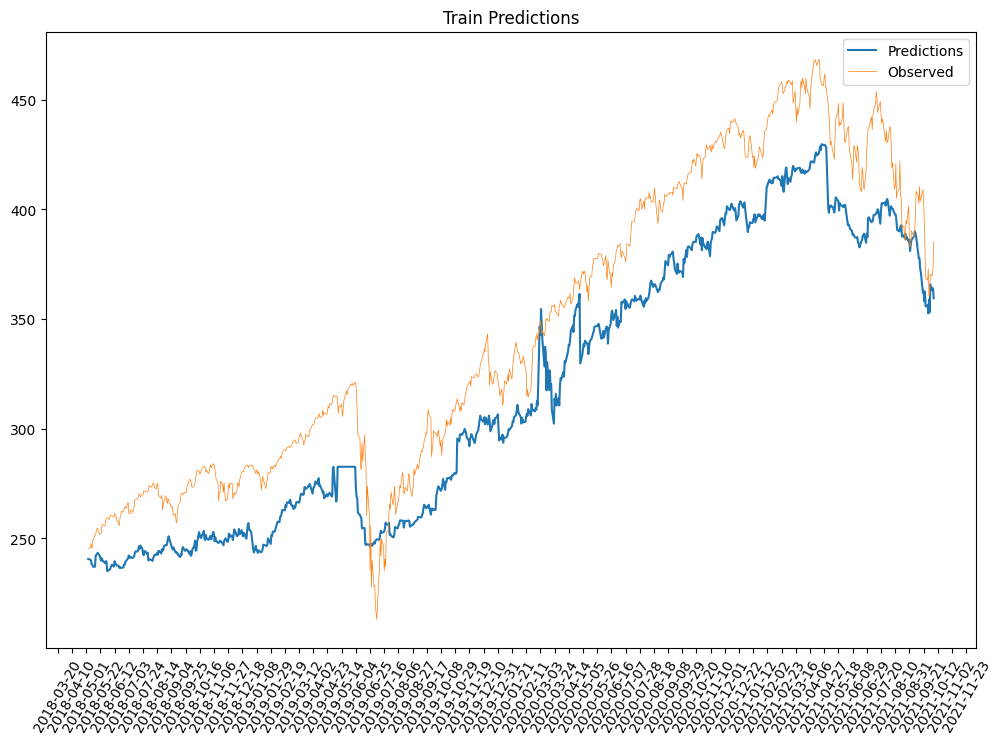

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

preds_train = pd.DataFrame({
    'Date': data_orig_final['Date'][:split_idx],
    'Predictions': x_pred,
    'Observed': data_orig_final['close_price_lagged'][:split_idx]
})

preds_train.to_csv('train_pred.csv')
!cp train_pred.csv "$path"

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Train Predictions')
ax.plot('Date', 'Predictions', data=preds_train, label='Predictions')
ax.plot('Date', 'Observed', data=preds_train, label='Observed', linewidth=0.5) # set alpha to 0.5 for the Observed line
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax.legend()
plt.show()

In [14]:
data_orig_final.shape

(1259, 42)

In [15]:
len(y_pred)

216

'cp' is not recognized as an internal or external command,
operable program or batch file.


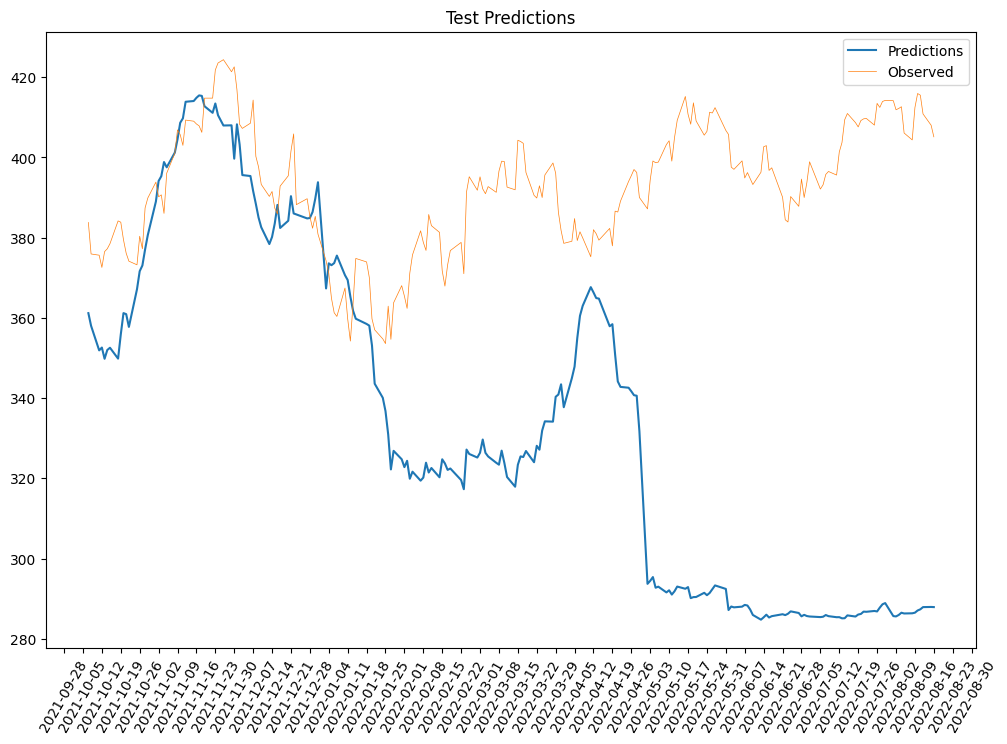

In [16]:
import matplotlib.pyplot as plt
preds_test = pd.DataFrame({
    'Date': data_orig_final['Date'][split_idx: data_orig_final.shape[0]-180],
    'Predictions': y_pred,
    'Observed': data_orig_final['close_price_lagged'][split_idx: data_orig_final.shape[0]-180]
})

preds_test.to_csv('test_pred.csv')
!cp test_pred.csv "$path"

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Test Predictions')
ax.plot('Date', 'Predictions', data=preds_test, label='Predictions')
ax.plot('Date', 'Observed', data=preds_test, label='Observed', linewidth=0.5) # set alpha to 0.5 for the Observed line
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.legend()
plt.show()

In [52]:
# Predict next 6 months
# Prepare the data
#Reshape X to match LSTM input shape
new_pred = model.predict(new_data_X)
new_pred = [x[0] for x in new_pred]
new_pred[:5]

6/6 [==============================] - 0s 2ms/step


[304.3834, 312.7185, 321.93, 329.81747, 336.85425]

In [54]:
data_orig_final.head()

,Date,close,volume,day,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,interest_rates,benz_rate,Year,Day,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,close_price_lagged
0,2018-05-04,244.288,91222100.0,4.0,0.039,-0.012,0.051,-190.728,-260.374,-260.374,-205.515,-205.515,-370.093,-370.093,1.640,62.119,62.119,242.621,242.621,242.621,242.621,14.77,118.99,101.64,83.19,1.7,7.189,2018,4,0,0,0,0,1,0,0,0,0,0,0,0,245.502
1,2018-05-07,245.114,55304900.0,0.0,0.127,0.029,0.097,-155.361,-225.370,-225.370,-212.133,-212.133,-251.843,-251.843,2.107,67.818,67.818,243.120,243.120,243.120,243.120,14.75,118.80,101.59,83.19,1.7,7.667,2018,7,0,0,0,0,1,0,0,0,0,0,0,0,245.633
2,2018-05-08,245.114,67499200.0,1.0,0.177,0.069,0.108,-155.361,-202.033,-202.033,-208.767,-208.767,-188.567,-188.567,2.107,67.818,67.818,243.452,243.452,243.452,243.452,14.71,118.69,101.42,83.20,1.7,6.600,2018,8,0,0,0,0,1,0,0,0,0,0,0,0,247.711
3,2018-05-09,247.483,59666100.0,2.0,0.313,0.131,0.182,-106.900,-170.322,-170.322,-195.952,-195.952,-119.063,-119.063,3.661,78.548,78.548,244.028,244.028,244.028,244.028,13.42,117.98,101.19,83.16,1.7,7.111,2018,9,0,0,0,0,1,0,0,0,0,0,0,0,245.829
4,2018-05-10,249.797,72063900.0,3.0,0.510,0.222,0.288,-69.359,-136.668,-136.668,-176.191,-176.191,-57.623,-57.623,5.296,84.118,84.118,244.749,244.749,244.749,244.749,13.23,118.93,101.40,83.16,1.7,9.000,2018,10,0,0,0,0,1,0,0,0,0,0,0,0,245.502


'cp' is not recognized as an internal or external command,
operable program or batch file.


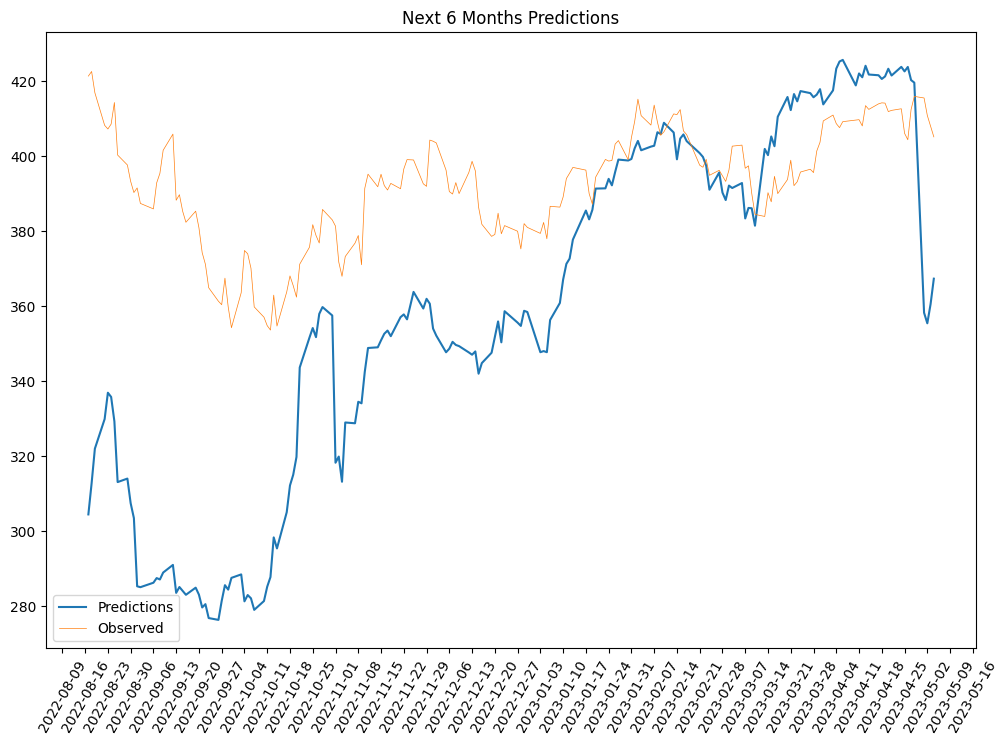

In [55]:
import matplotlib.pyplot as plt
new_preds = pd.DataFrame({
    'Date': new_data_original['Date'],
    'Predictions': new_pred,
    'Observed': data_orig_final['close'][data_orig_final.shape[0]-180:]
})

new_preds.to_csv('new_preds.csv')
!cp new_preds.csv "$path"

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Next 6 Months Predictions')
ax.plot('Date', 'Predictions', data=new_preds, label='Predictions')
ax.plot('Date', 'Observed', data=new_preds, label='Observed', linewidth=0.5)
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.legend()
plt.show()

In [ ]:
date_new = pd.concat([appts_model['Date'], new_data['Date']], axis=0)
len_zeros = int(len(date_new)-len(appts_model['StudentName']))
observed_new = pd.concat([appts_model['StudentName'], pd.Series(np.zeros(len_zeros))], axis=0)
predictions_new = pd.concat([preds_train['Predictions'], preds_test['Predictions'], new_preds['Predictions']])

predictions_concat = pd.DataFrame({
    'Date': date_new,
    'Observed': observed_new,
    'Predictions': predictions_new
})

In [ ]:
import plotly.graph_objs as go
import pandas as pd

# Create a trace for the observed values
trace_observed = go.Scatter(x=predictions_concat['Date'], y=predictions_concat['Observed'], name='Observed')

# Create a trace for the predictions
trace_predictions = go.Scatter(x=predictions_concat['Date'], y=predictions_concat['Predictions'], name='Predictions')

# Create a layout for the graph
layout = go.Layout(
    title='Next 6 Months Predictions',
    xaxis=dict(title='Date', tickangle=60),
    yaxis=dict(title='Values'),
)

# Create a figure and add the traces and layout
fig = go.Figure(data=[trace_observed, trace_predictions], layout=layout)

# Show the graph
fig.show()